In [1]:
from lxml import html
import requests
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [121]:
r = urllib2.urlopen('http://www.buda.org/leagues/past-leagues')
soup = BeautifulSoup(r, 'html.parser')
iframe = soup.find_all('iframe')[0]
response = urllib2.urlopen(iframe.attrs['src'])
iframe_soup = BeautifulSoup(response)
leaguelinks = [i.a['href'] for i in iframe_soup.find_all("td", class_="infobody")]

In [2]:
picklefile = '../all_players.p'

In [3]:
all_players = pickle.load( open( picklefile, "rb" ) )

In [4]:
pmean = []
players_means = {}
for player in all_players.keys():
    pratings = np.array(all_players[player])
    toolow = np.where(pratings < 0)
    if toolow[0].size > 0:
        pratings[toolow[0]] = 0
    pmean.append(pratings.mean())
    if pratings.mean() < 0:
        print(pratings)
    players_means[player] = pratings.mean()

In [127]:
# teamratings = {}
# playerlist = {}
teamavgratings = {}
# teamself = {}
# teamcaptain = {}
# teamcombined = {}
truedifferential = {}

# loop over all leagues in the BUDA database
for link in leaguelinks:

    # extract the league id for this league
    leagueid = link[link.index('league=') + 7:]


    # extract the league id for this league
    # springhat2016id = '30924'
#     leagueid = springhat2016id
    print("Working on league {}".format(leagueid))

    # scrape the list of teams for this league
    teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
    response = urllib2.urlopen(teamsurl)
    teams_soup = BeautifulSoup(response)

    # generate list of team ids and names for this league
    tdlist = teams_soup.find_all('td', class_='infobody')
    teamids = []
    teamnames = []
    for td in tdlist:
        try:
            url = td.a['href']
            idindex = url.index('team=')
            whichindex = url.index('which=')
            teamids.append(url[idindex+5:whichindex-1])
            teamnames.append(td.a.get_text())
        except:
            continue

    # if this league is complete, get the true score differential for each team

    # scrape the scores for this league
    leaguescoreurl = 'http://www.buda.org/hatleagues/scores.php?section=showLeagueSchedule&league=' + leagueid + '&byDivision=1&showGames=0'
    response = urllib2.urlopen(leaguescoreurl)
    leaguescore_soup = BeautifulSoup(response)

    # assemble the data of team ratings for this league
    print("Building database of team ratings")
    data = []
    data_opponent = []
    try:
        table = leaguescore_soup.find_all('table', attrs={'class':'info'})[1]
    except IndexError:
        print("Unable to find a database of scores for league {}".format(leagueid))
        continue
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('th')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values

    # convert to dataframe and drop irrelevant columns
    dfdata = pd.DataFrame(data)
    #     print(leagueid, dfdata.columns)
    dfdata.columns = dfdata.ix[0, :]#['Team', 'Record', 'Plus/Minus', 'Tourney Qualifying games']
    #     print(leagueid, dfdata.columns)
    dfdata = dfdata.drop(0).reset_index()

    # fill na's with -99 to facilitate division dividers
    dfdata = dfdata.fillna(-99)

    # get the list of divisions in this league
    divnames = dfdata.ix[dfdata['Record'] == -99, 'Team'].values
    if len(divnames) == 0:
        print("No divisions found, skipping league {}".format(leagueid))
    #     continue

    dfdata['div'] = np.zeros(len(dfdata))
    for i in range(len(divnames)-1):
        try:
            divstart = np.where(dfdata['Team'] == divnames[i])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i], leagueid))
    #         continue
        try:
            divend = np.where(dfdata['Team'] == divnames[i + 1])[0][0]
        except IndexError:
            print("{} not found, skipping league {}".format(divnames[i + 1], leagueid))
    #         continue
        try:
            dfdata.ix[divstart + 1: divend, 'div'] = divnames[i]
        except KeyError:
            print("No base rating for {}, skipping league {}".format(divnames[i], leagueid))
    #         continue
    try:
        dfdata.ix[divend + 1:, 'div'] = divnames[-1]
    except KeyError:
        print("No base rating for {}, skipping league {}".format(divnames[-1], leagueid))
    #     continue

    # remove the division dividers from the dataframe
    for i in range(len(divnames)):
        dfdata = dfdata.drop(dfdata.index[dfdata['Team'] == divnames[i]])

    # generate the average goal differential column
    dfdata['wins'] = dfdata['Record'].apply(lambda x: int(x.split('-')[0]))
    dfdata['losses'] = dfdata['Record'].apply(lambda x: int(x.split('-')[1]))
    dfdata['games'] = dfdata['wins'] + dfdata['losses']
    dfdata['avgplusminus'] = dfdata['Plus/Minus'].astype('float') / dfdata['games']

    # find all players associated with each team
    print("Finding all players associated with each team")
    for teamid, teamname in zip(teamids, teamnames):

        teamurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeamRoster&team=' + teamid
        response = urllib2.urlopen(teamurl)
        roster_soup = BeautifulSoup(response)

        playerratings = []
        selfrating = []
        captainrating = []
        combinedrating = []
        players = [td.get_text() for td in roster_soup.find_all("td", class_="infobody")]
        for player in players:
            if player == '':
                continue
            if player in all_players:
                playerratings.append(players_means[player])
            else:
                # if someone hasn't played club league, they probably aren't very good
                playerratings.append(700)
            PLAYER = player.upper()
    #         if player == 'Bussmann, Shane':
    #             import pdb; pdb.set_trace()
            if PLAYER in sph2011['full name'].values:
    #             import pdb; pdb.set_trace()
                sph2011row = sph2011['full name'] == PLAYER
                selfrating.append(sph2011.ix[sph2011row, 'Self'].values[0])
                captainrating.append(sph2011.ix[sph2011row, 'CR'].values[0])
                combinedrating.append(sph2011.ix[sph2011row, 'Rating'].values[0])
        # the team rating is the average of the player ratings for that team
#         teamratings[teamname] = playerratings
#         playerlist[teamname] = players
        teamavgratings[teamname] = np.mean(playerratings)
#         teamself[teamname] = np.mean(selfrating)
#         teamcaptain[teamname] = np.mean(captainrating)
#         teamcombined[teamname] = np.mean(combinedrating)
    #     print("Finished with team {}".format(teamname))
        dfdatarow = dfdata['Team'] == teamname
        truedifferential[teamname] = dfdata.ix[dfdatarow, 'avgplusminus'].values[0]
        
        dfdata['divmean'] = np.zeros(len(dfdata))
        for div in divnames:
            divmean = np.mean(dfdata.ix[dfdata['div'] == div, 'Historical Rating'])
            allteamdf.ix[allteamdf['div'] == div, 'divmean'] = divmean

    print("Finished successfully with league {}".format(leagueid))
    print("")
#     import pdb; pdb.set_trace()

Working on league 40491
Building database of team ratings
Unable to find a database of scores for league 40491
Working on league 40278
Building database of team ratings
Finding all players associated with each team
Finished successfully with league 40278

Working on league 40273
Building database of team ratings
Finding all players associated with each team
Finished successfully with league 40273

Working on league 40268
Building database of team ratings
Unable to find a database of scores for league 40268
Working on league 40264
Building database of team ratings
Unable to find a database of scores for league 40264
Working on league 40258
Building database of team ratings
Finding all players associated with each team
Finished successfully with league 40258

Working on league 40253
Building database of team ratings
Finding all players associated with each team
Finished successfully with league 40253

Working on league 40249
Building database of team ratings
Unable to find a database of 

In [146]:
tdiff[0]

46    0.705882
Name: avgplusminus, dtype: float64

In [144]:
tag = np.array(teamavgratings.values())
tdiff = np.array(truedifferential.values())
ok = np.where(np.abs(tdiff) < 1e4)
tag = tag[ok]
plt.plot(tdiff[ok], tag, 'o')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [141]:
tag

[1579.8208061183182,
 1012.9647022946754,
 992.44550596165573,
 1131.6961580077641,
 892.82459847844461,
 936.69261052169782,
 1128.2119202811073,
 1061.708407271859,
 946.15549137515598,
 996.36542503299086,
 1597.7704036159919,
 965.84493663111959,
 1215.8000006180791,
 700.0,
 1423.4379699197207,
 958.87395409353314,
 789.94845193868628,
 1450.1281401338424,
 749.90840226487478,
 1028.0266598594014,
 1542.6825648245101,
 828.0934619574324,
 1048.6736173372501,
 1124.2133868396286,
 1327.0228524651982,
 1055.7734539488681,
 1508.2642614381487,
 976.88402205482043,
 1335.5336046031205,
 1502.7746677797543,
 924.72205862483406,
 962.45576768616183,
 1154.0517169864113,
 1080.6603772759104,
 1126.8849055313999,
 895.12473189730326,
 1108.717207743744,
 739.51838055107282,
 1663.73311410624,
 1051.7495954349663,
 884.75747057263823,
 742.7649419616331,
 1041.6669175948748,
 1187.7686202686202,
 1102.3801139621185,
 788.49581076449715,
 875.31468106412001,
 1150.1036675344089,
 1372.54993

In [5]:
allratings = pd.DataFrame({'Historical Rating': teamavgratings.values(), 
#                            'Self Rating': teamself.values(),
#                            'Captain Rating': teamcaptain.values(),
#                            'Combined Rating': teamcombined.values(),
                           'Team': teamavgratings.keys()})
alltruediff = pd.DataFrame({'Team': truedifferential.keys(), 'avgplusminus': truedifferential.values()})

alltrueratings = allratings.merge(alltruediff, on='Team', how='inner')
alltrueratings = alltrueratings.set_index('Team')

NameError: name 'teamavgratings' is not defined

In [123]:
alltrueratings

,Historical Rating,avgplusminus
Team,,


In [112]:
allteamdf = teamdf.join(allratings)

In [115]:
allteamdf['divmean'] = np.zeros(len(allteamdf))
for div in divnames:
    divmean = np.mean(allteamdf.ix[allteamdf['div'] == div, 'Historical Rating'])
    allteamdf.ix[allteamdf['div'] == div, 'divmean'] = divmean

In [117]:
allteamdf['Relative Historical Rating'] = allteamdf['Historical Rating'] - allteamdf['divmean']

In [59]:
def teamnumber(x):
    i0 = x.index('(')
    i1 = x.index(')')
    return x[i0+1:i1]

In [82]:
allteamdf.index

Index([u'Phantasmagoric Phearless Phlckrs (32)', u'Huckwing Duck (36)',
       u'GI Throw (31)', u'Fantastic Force (38)', u'Just Disc League (30)',
       u'D'Ninjas (27)', u'Incredible Huck (33)', u'Baby Blue Avengers (34)',
       u'Superflick (28)', u'Sandman (35)', u'Hellboy The Golden Army (26)',
       u'The Biddler (29)', u'League of Extraordinary Handlers (25)',
       u'Aqua Teen Hucking Force (37)', u'Darkwing Huck (42)',
       u'Pullverine (41)', u'Superman Fortyhands (40)',
       u'Powdered Toast Man (39)', u'The Avengers (23)',
       u'Aqua Team Huck 'N Force (22)', u'Thor's Hammer (9)',
       u'The Incredible Huck (15)', u'Skynet (5)', u'Fantastic Forehand (7)',
       u'Xena Warrior Princess (24)', u'Doctor Horrible Decision (3)',
       u'Cuptonite (18)', u'Blade (11)', u'To The Hatmobile! (10)',
       u'Scooberman (1)', u'Underdog (14)', u'RadioStacktive Man (4)',
       u'Tiger Blood (17)', u'Ambiguously Gray Duos (20)',
       u'Purple Poacher Eaters (8)', u'Hol

In [104]:
allteamdf['teamnumber'] = allteamdf.index.str.extract('\((.*)\)').values.astype('int')

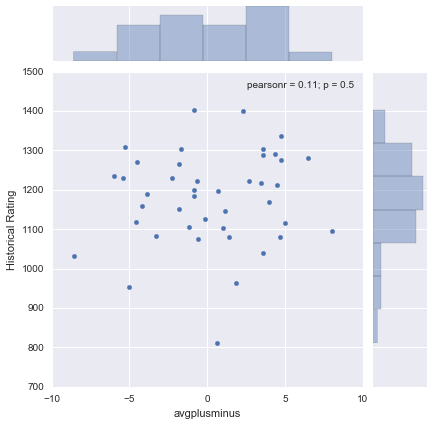

In [52]:
sns.jointplot(allteamdf['avgplusminus'], allteamdf['Historical Rating'])

In [105]:
jpmixed = allteamdf[allteamdf['teamnumber'] < 25]

In [106]:
allteamdf['teamnumber'].values.astype('int')

array([32, 36, 31, 38, 30, 27, 33, 34, 28, 35, 26, 29, 25, 37, 42, 41, 40,
       39, 23, 22,  9, 15,  5,  7, 24,  3, 18, 11, 10,  1, 14,  4, 17, 20,
        8, 16, 13,  2, 19, 21,  6, 12])

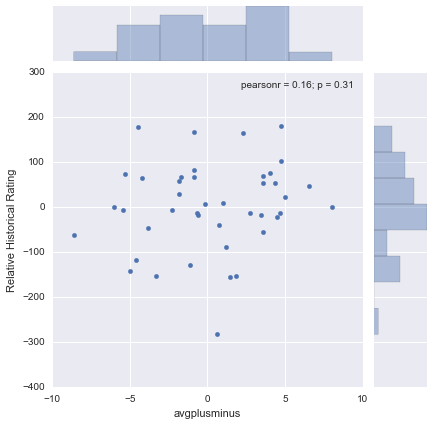

In [119]:
sns.jointplot(allteamdf['avgplusminus'], allteamdf['Relative Historical Rating'])

In [45]:
draftteams = allteamdf.dropna(subset=['Self Rating'])
draftteams = draftteams[draftteams['games'] > 5]

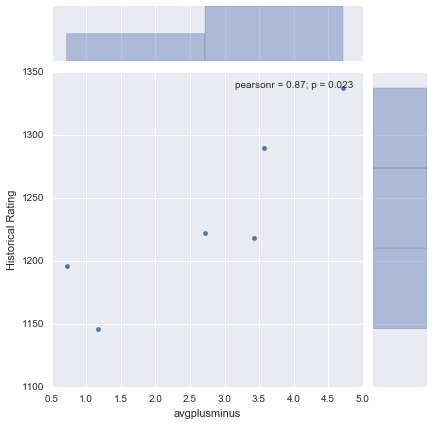

In [47]:
sns.jointplot(draftteams['avgplusminus'], draftteams['Historical Rating'])

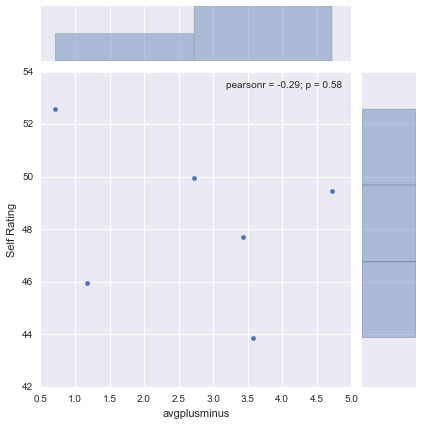

In [46]:
sns.jointplot(draftteams['avgplusminus'], draftteams['Self Rating'])

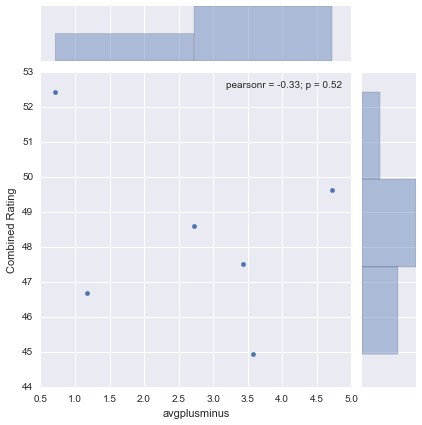

In [50]:
sns.jointplot(draftteams['avgplusminus'], draftteams['Combined Rating'])

In [1]:
def printteam(teamratings, playerlist, team):
    print(team)
    for i in range(len(teamratings[team])):
        print("{:20} {:5.0f}".format(playerlist[team][i], teamratings[team][i]))
    print("")

In [2]:
def plot2teams(teamratings, team1, team2):
    plt.plot(np.cumsum(np.sort(teamratings[team1])), 'o-', label=team1)
    plt.plot(np.cumsum(np.sort(teamratings[team2])), 'o-', label=team2)
    plt.legend()
#     printteam(teamratings, playerlist, team1)
#     printteam(teamratings, playerlist, team2)

I need a function that takes a league id as input, and then:
 - for every team in the league
   - gets the rating for each player on the team
   - computes the team rating using the average player rating for that team
   - predicts point differential over the full season
   - gets the true point differential for the full season
 - makes a plot comparing true vs. predicted point differential for that league
 
For spring hat league 2011, I have captain's ratings and self ratings for every player in Monday night hat league.  The money plot will be a comparison of predicted and true point differential for three possible metrics: the rating system I've devised here (let's call it "historical experience rating"), self rating, and captain's rating.  I'll bet that there is a stronger correlation between true point differential and HER than there is for either self rating or captain's rating.

In [7]:
# load spring hat league self ratings and captain's ratings
sph2011file = '/Users/rbussman/Documents/ultimate/sphl11_mon_draft.csv'
sph2011 = pd.read_csv(sph2011file)

In [8]:
sph2011['full name'] = sph2011['LAST'] + ', ' + sph2011['FIRST']

#### Validation on the current season: Predictions for every R2Defense game.

In [9]:
teamratings = {}
playerlist = {}
teamavgratings = {}
# teamself = {}
# teamcaptain = {}
# teamcombined = {}
truedifferential = {}

# extract the league id for this league
leagueid = '40258'


# extract the league id for this league
# springhat2016id = '30924'
#     leagueid = springhat2016id
print("Working on league {}".format(leagueid))

# scrape the list of teams for this league
teamsurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeams&league=' + leagueid
response = urllib2.urlopen(teamsurl)
teams_soup = BeautifulSoup(response)

# generate list of team ids and names for this league
tdlist = teams_soup.find_all('td', class_='infobody')
teamids = []
teamnames = []
for td in tdlist:
    try:
        url = td.a['href']
        idindex = url.index('team=')
        whichindex = url.index('which=')
        teamids.append(url[idindex+5:whichindex-1])
        teamnames.append(td.a.get_text())
    except:
        continue

# if this league is complete, get the true score differential for each team

# scrape the scores for this league
leaguescoreurl = 'http://www.buda.org/hatleagues/scores.php?section=showLeagueSchedule&league=' + leagueid + '&byDivision=1&showGames=0'
response = urllib2.urlopen(leaguescoreurl)
leaguescore_soup = BeautifulSoup(response)

# assemble the data of team ratings for this league
print("Building database of team ratings")
data = []
data_opponent = []
try:
    table = leaguescore_soup.find_all('table', attrs={'class':'info'})[1]
except IndexError:
    print("Unable to find a database of scores for league {}".format(leagueid))
#     continue
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('th')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

# convert to dataframe and drop irrelevant columns
dfdata = pd.DataFrame(data)
#     print(leagueid, dfdata.columns)
dfdata.columns = dfdata.ix[0, :]#['Team', 'Record', 'Plus/Minus', 'Tourney Qualifying games']
#     print(leagueid, dfdata.columns)
dfdata = dfdata.drop(0).reset_index()

# fill na's with -99 to facilitate division dividers
dfdata = dfdata.fillna(-99)

# get the list of divisions in this league
divnames = dfdata.ix[dfdata['Record'] == -99, 'Team'].values
if len(divnames) == 0:
    print("No divisions found, skipping league {}".format(leagueid))
#     continue

dfdata['div'] = np.zeros(len(dfdata))
for i in range(len(divnames)-1):
    try:
        divstart = np.where(dfdata['Team'] == divnames[i])[0][0]
    except IndexError:
        print("{} not found, skipping league {}".format(divnames[i], leagueid))
#         continue
    try:
        divend = np.where(dfdata['Team'] == divnames[i + 1])[0][0]
    except IndexError:
        print("{} not found, skipping league {}".format(divnames[i + 1], leagueid))
#         continue
    try:
        dfdata.ix[divstart + 1: divend, 'div'] = divnames[i]
    except KeyError:
        print("No base rating for {}, skipping league {}".format(divnames[i], leagueid))
#         continue
try:
    dfdata.ix[divend + 1:, 'div'] = divnames[-1]
except KeyError:
    print("No base rating for {}, skipping league {}".format(divnames[-1], leagueid))
#     continue

# remove the division dividers from the dataframe
for i in range(len(divnames)):
    dfdata = dfdata.drop(dfdata.index[dfdata['Team'] == divnames[i]])

# generate the average goal differential column
dfdata['wins'] = dfdata['Record'].apply(lambda x: int(x.split('-')[0]))
dfdata['losses'] = dfdata['Record'].apply(lambda x: int(x.split('-')[1]))
dfdata['games'] = dfdata['wins'] + dfdata['losses']
dfdata['avgplusminus'] = dfdata['Plus/Minus'].astype('float') / dfdata['games']

# find all players associated with each team
print("Finding all players associated with each team")
for teamid, teamname in zip(teamids, teamnames):

    teamurl = 'http://www.buda.org/hatleagues/rosters.php?section=showTeamRoster&team=' + teamid
    response = urllib2.urlopen(teamurl)
    roster_soup = BeautifulSoup(response)

    playerratings = []
    selfrating = []
    captainrating = []
    combinedrating = []
    players = [td.get_text() for td in roster_soup.find_all("td", class_="infobody")]
    for player in players:
        if player == '':
            continue
        if player in all_players:
            playerratings.append(players_means[player])
        else:
            # if someone hasn't played club league, they probably aren't very good
            playerratings.append(700)
        PLAYER = player.upper()
#         if player == 'Bussmann, Shane':
#             import pdb; pdb.set_trace()
        if PLAYER in sph2011['full name'].values:
#             import pdb; pdb.set_trace()
            sph2011row = sph2011['full name'] == PLAYER
            selfrating.append(sph2011.ix[sph2011row, 'Self'].values[0])
            captainrating.append(sph2011.ix[sph2011row, 'CR'].values[0])
            combinedrating.append(sph2011.ix[sph2011row, 'Rating'].values[0])
    # the team rating is the average of the player ratings for that team
    teamratings[teamname] = playerratings
    playerlist[teamname] = players
    teamavgratings[teamname] = np.mean(playerratings)
#         teamself[teamname] = np.mean(selfrating)
#         teamcaptain[teamname] = np.mean(captainrating)
#         teamcombined[teamname] = np.mean(combinedrating)
#     print("Finished with team {}".format(teamname))
#     dfdatarow = dfdata['Team'] == teamname
#     truedifferential[teamname] = dfdata.ix[dfdatarow, 'avgplusminus'].values[0]

#     dfdata['divmean'] = np.zeros(len(dfdata))
#     for div in divnames:
#         divmean = np.mean(dfdata.ix[dfdata['div'] == div, 'Historical Rating'])
#         allteamdf.ix[allteamdf['div'] == div, 'divmean'] = divmean

print("Finished successfully with league {}".format(leagueid))
print("")
#     import pdb; pdb.set_trace()

Working on league 40258
Building database of team ratings
Finding all players associated with each team
Finished successfully with league 40258



In [10]:
teamavgratings

{u'107 Dalmatians (24)': 1196.299609679045,
 u'Air Bud VII Break Bark (8)': 1130.4406224010686,
 u'Backhand vs Scooberman (17)': 1159.6143488652363,
 u'Bar Bar Drinks (16)': 1112.2916831323746,
 u'Chewblocka (3)': 1354.8616142817584,
 u'Clifford the Big Red Wookie (30)': 1164.6385826881904,
 u'Cloud City United  (28)': 977.88797434574326,
 u"Ernest goes to Doyle's (5)": 1094.3057033929615,
 u'Fifty Shades of Rey (9)': 1097.2507315727357,
 u'Furious 7 Lassies on the Line (6)': 1143.571308511396,
 u'Golden BUDA (29)': 1041.3869065101123,
 u'Hammers Are Forever (18)': 1125.9850968326457,
 u'Jedi Mind Flicks (27)': 1040.3566902136567,
 u'Kylo Red (22)': 1183.0444835092667,
 u'Mark Hammer (1)': 1059.4535387703113,
 u'Marooned on Jakku (14)': 1268.4454112760307,
 u'Never Teal Me The Odds (4)': 1073.2589911085906,
 u'Orange is the New Darkside (11)': 1314.7487106110952,
 u'Poe Hammeron (15)': 1113.559230080444,
 u'Princess Layout (19)': 1203.7280616274645,
 u'R2Defense (20)': 1077.29928210073

In [11]:
names = []
predrating = []
for key in teamavgratings.keys():
    names.append(key)
    predrating.append(teamavgratings[key])
#     print("{:38} {:.0f}".format(key, teamavgratings[key]) )
dfpred = pd.DataFrame({'teamname': names, 'predictedrating': predrating})

In [13]:
dfpred.sort('predictedrating')

,predictedrating,teamname
25,977.887974,Cloud City United (28)
16,1032.370549,Too Fast 7 Furious (7)
12,1040.356690,Jedi Mind Flicks (27)
2,1041.386907,Golden BUDA (29)
19,1059.453539,Mark Hammer (1)
22,1073.258991,Never Teal Me The Odds (4)
1,1077.299282,R2Defense (20)
26,1078.465678,Team TBD (25)
3,1094.305703,Ernest goes to Doyle's (5)
4,1097.250732,Fifty Shades of Rey (9)


In [35]:
(1077 - 1900/16. - 1400/16.) * 16/14.

995.1428571428571

In [3]:
plot2teams(teamratings, 'R2Defense (20)', 'Poe Hammeron (15)')

NameError: name 'teamratings' is not defined

In [4]:
plot2teams(teamratings, 'R2Defense (20)', 'Team 14 (14)')

NameError: name 'teamratings' is not defined

In [5]:
plot2teams(teamratings, 'R2Defense (20)', 'Team 24 (24)')

NameError: name 'teamratings' is not defined

In [6]:
plot2teams(teamratings, 'R2Defense (20)', 'Team 22 (22)')

NameError: name 'teamratings' is not defined

In [7]:
plot2teams(teamratings, 'R2Defense (20)', 'Winning the Pooh (13)')

NameError: name 'teamratings' is not defined

In [8]:
plot2teams(teamratings, 'R2Defense (20)', 'Team 16 (16)')

NameError: name 'teamratings' is not defined

In [9]:
plot2teams(teamratings, 'R2Defense (20)', 'Team 18 (18)')

NameError: name 'teamratings' is not defined

In [10]:
np.sort(teamratings['R2Defense (20)'])

NameError: name 'np' is not defined